# ML4Oceans Summer School 2022- Image classification

The goal of this practical course is to understand how transformers work for image classification and how to train them. 
We will work on a problem of image classification of plankton images.
First we will study the data and in particular their distribution. Then we will train convnets and transformers for the classification of these images. We will then analyze the predictions in order to improve the models.

# Test GPU

We check that we have access to a GPU and we look at what memory it has in order to better adjust our batch size.

In [1]:
import os

# allow downloads
os.environ['HTTP_PROXY'] = "192.168.0.100:3128"
os.environ['HTTPS_PROXY'] = "192.168.0.100:3128"

# give the index of the CUDA device (the GPU)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch

print("CUDA is there: ", torch.cuda.is_available())
print("CUDA device is: ", torch.cuda.get_device_name(0))

!nvidia-smi

CUDA is there:  True
CUDA device is:  TITAN X (Pascal)
Thu Sep  1 14:52:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 00000000:02:00.0 Off |                  N/A |
| 23%   26C    P8     9W / 250W |      2MiB / 12196MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                 

# Data exploration and preparation

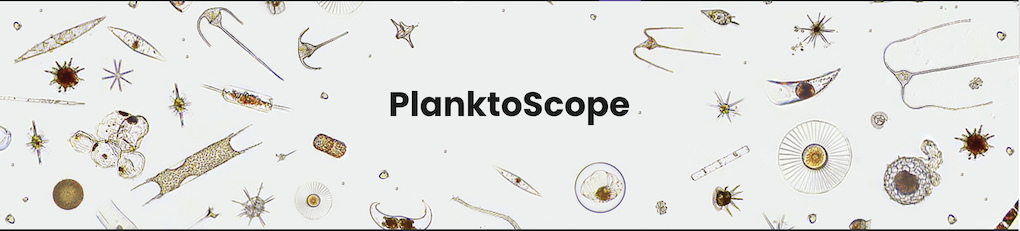

The data is in the folder `planktoscope`.

We will analyze the data we have. In particular we will visualize the images and look at the distribution of the classes.

In [92]:
import pandas as pd

from PIL import Image

import os
import os.path as osp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import warnings
warnings.filterwarnings("ignore")

## Features and labels exploration

Read features (measurements on each image) and labels.

In [93]:
features = pd.read_csv('planktoscope/features.csv')
labels = pd.read_csv('planktoscope/labels.csv')

In [94]:
features

,image,area,convex_area,filled_area,solidity,centroid-0,centroid-1,perimeter,feret_diameter_max,major_axis_length,...,weighted_moments_hu-3-2,weighted_moments_hu-4-0,weighted_moments_hu-4-1,weighted_moments_hu-4-2,weighted_moments_hu-5-0,weighted_moments_hu-5-1,weighted_moments_hu-5-2,weighted_moments_hu-6-0,weighted_moments_hu-6-1,weighted_moments_hu-6-2
0,241828061.jpg,674,922,695,0.731020,31.727003,31.795252,198.302561,38.910153,32.723485,...,1.769563e-11,5.410661e-24,-8.471471e-24,-3.704206e-22,2.798675e-16,6.037845e-17,2.016910e-15,3.858769e-23,2.687703e-24,-1.778263e-21
1,241828062.jpg,1285,1679,1285,0.765337,48.038911,42.128405,189.681241,54.644304,47.266476,...,4.237097e-13,1.481282e-24,-3.948123e-24,-1.978557e-24,-1.555624e-17,6.272570e-16,-1.359088e-16,-5.996477e-25,-2.559898e-23,7.393941e-25
2,241828063.jpg,3311,4800,3515,0.689792,77.536696,75.024464,504.416306,94.260278,72.750915,...,3.786703e-10,6.500128e-23,-1.330822e-22,1.201282e-19,1.196717e-15,9.117066e-16,6.174671e-14,2.946583e-22,5.534280e-22,7.602144e-20
3,241828064.jpg,8910,11827,9551,0.753361,132.898653,132.311560,1442.947402,145.986301,121.174426,...,4.495510e-12,4.510512e-24,3.022963e-24,-3.316082e-24,3.804776e-16,3.887097e-16,8.563452e-16,1.045332e-23,1.076679e-23,2.878884e-23
4,241828065.jpg,2816,8445,2854,0.333452,80.730114,71.145241,1225.424494,127.632284,97.903691,...,1.938255e-12,-9.376654e-23,-8.941291e-23,-1.461033e-23,4.913644e-16,4.618987e-16,4.000425e-16,2.285861e-22,2.095709e-22,9.844163e-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123169,242041475.jpg,4147,5592,4173,0.741595,83.170002,108.864480,517.339141,143.338760,135.690323,...,1.824461e-10,1.956843e-19,1.182266e-19,5.273868e-20,9.051630e-13,6.482590e-13,3.883664e-13,-2.215861e-20,-7.726430e-21,-5.565976e-21
123170,242041476.jpg,8911,27762,10683,0.320978,383.221187,212.589496,3616.611578,367.609848,353.784037,...,2.045702e-08,4.728957e-16,4.256655e-16,4.930791e-16,8.793195e-11,8.269641e-11,9.175115e-11,-3.783239e-17,-3.608390e-17,-3.522375e-17
123171,242041477.jpg,8644,28099,10315,0.307627,457.691925,215.487043,3363.681600,375.857686,350.220311,...,2.333429e-08,7.589694e-16,6.968401e-16,7.587164e-16,7.317302e-11,6.816599e-11,7.311776e-11,-2.158813e-16,-2.066484e-16,-2.189065e-16
123172,242041478.jpg,22879,82876,24773,0.276063,342.216880,338.184099,13731.509012,583.305237,508.945320,...,1.348938e-08,2.694465e-16,2.721126e-16,2.621704e-16,3.042364e-11,3.055292e-11,2.986546e-11,7.561422e-17,7.628313e-17,7.308447e-17


In [95]:
features.describe()

,area,convex_area,filled_area,solidity,centroid-0,centroid-1,perimeter,feret_diameter_max,major_axis_length,minor_axis_length,...,weighted_moments_hu-3-2,weighted_moments_hu-4-0,weighted_moments_hu-4-1,weighted_moments_hu-4-2,weighted_moments_hu-5-0,weighted_moments_hu-5-1,weighted_moments_hu-5-2,weighted_moments_hu-6-0,weighted_moments_hu-6-1,weighted_moments_hu-6-2
count,1.231740e+05,1.231740e+05,1.231740e+05,123174.000000,123174.000000,123174.000000,123174.000000,123174.000000,123174.000000,123174.000000,...,1.231740e+05,1.231740e+05,1.231740e+05,1.231740e+05,1.231740e+05,1.231740e+05,1.231740e+05,1.231740e+05,1.231740e+05,1.231740e+05
mean,3.676617e+03,1.265624e+04,4.145736e+03,0.527901,66.233778,86.651305,935.260650,154.607483,162.037982,45.870395,...,2.369611e-07,2.033725e-10,2.827741e-10,1.669728e-10,3.558710e-08,4.128589e-08,3.175842e-08,-1.282062e-13,-1.650275e-13,-1.666054e-13
std,2.179152e+04,1.038793e+05,2.543050e+04,0.180105,87.487692,115.908249,2980.857269,234.953380,262.283679,65.640219,...,1.291372e-05,3.422719e-08,5.735319e-08,2.658350e-08,4.110181e-06,5.432674e-06,3.516968e-06,1.786316e-11,1.885317e-11,1.977913e-11
min,3.300000e+01,3.400000e+01,3.300000e+01,0.039176,2.195652,3.085366,19.449747,8.062258,7.250024,2.551328,...,3.903018e-16,-2.230817e-09,-1.807132e-09,-1.465309e-09,-1.953205e-06,-1.653680e-06,-1.854484e-06,-4.384185e-09,-3.631888e-09,-4.630904e-09
25%,6.740000e+02,1.158000e+03,7.060000e+02,0.401823,33.260341,37.450448,235.409163,51.312766,51.381419,22.910124,...,9.212174e-11,-3.252742e-23,-4.207214e-23,-6.791921e-23,-2.261168e-15,-2.705053e-15,-3.816492e-15,-1.314792e-19,-1.589988e-19,-1.996606e-19
50%,1.027000e+03,1.943000e+03,1.125000e+03,0.516129,43.525364,53.562078,388.066540,76.967526,76.998412,32.293587,...,6.302131e-10,4.400719e-20,5.051203e-20,6.794186e-20,9.912481e-14,1.098749e-13,1.342209e-13,-4.852572e-27,-2.889012e-27,-2.364464e-26
75%,2.134000e+03,4.736000e+03,2.346000e+03,0.649123,66.604050,93.146997,766.715295,163.765075,167.359912,46.165334,...,5.948898e-09,1.308434e-17,1.527136e-17,1.804015e-17,7.161146e-12,8.031533e-12,8.742542e-12,1.296689e-19,1.543766e-19,1.961667e-19
max,1.534472e+06,8.032988e+06,3.233672e+06,0.981442,2382.857819,3787.412124,216020.515488,4715.927480,5570.875479,3724.121895,...,2.718030e-03,1.030011e-05,1.844645e-05,7.388570e-06,1.103945e-03,1.573578e-03,9.072572e-04,1.216830e-09,9.753844e-10,7.569477e-10


In [96]:
labels

,image,label
0,241828061.jpg,Rhizaria
1,241828062.jpg,Rhizaria
2,241828063.jpg,Rhizaria
3,241828064.jpg,Rhizaria
4,241828065.jpg,Rhizaria
...,...,...
123169,242041475.jpg,cyst
123170,242041476.jpg,ghost
123171,242041477.jpg,ghost
123172,242041478.jpg,ghost


## Data distribution

In [97]:
labels['label'].value_counts()

detritus             50000
Cyanobacteria        10409
round cells           6428
dry                   6217
transparent           5629
                     ...  
egg sac                 40
puff                    39
spines                  29
Spumellaria             24
Planktoniella sol       24
Name: label, Length: 84, dtype: int64

**Exercise** Plot the data distribution by class.

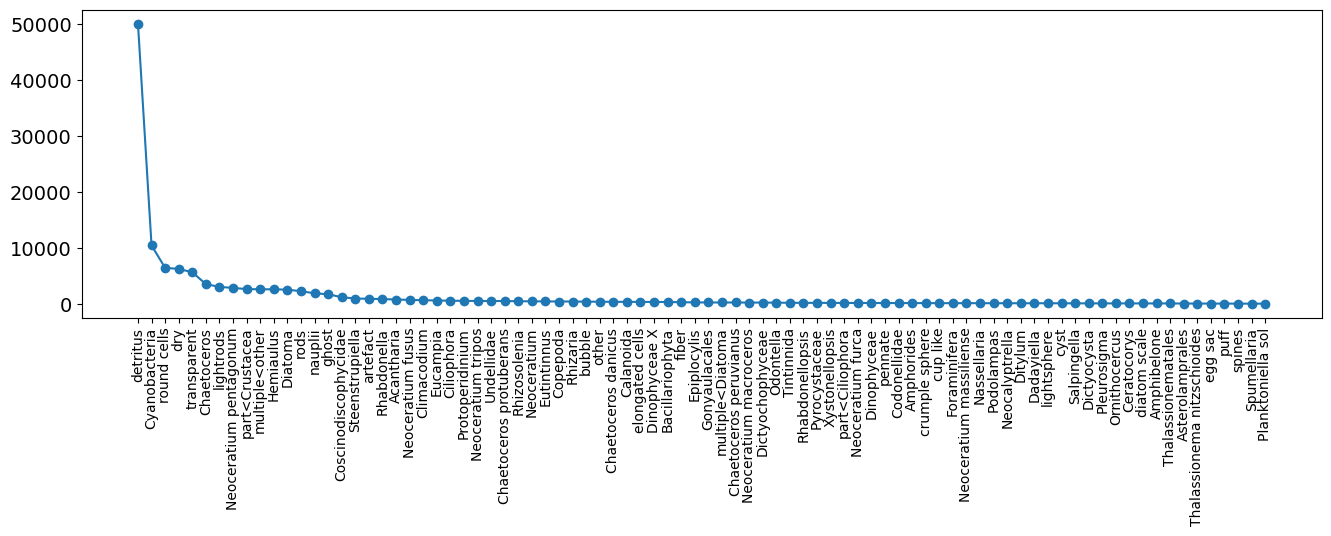

In [98]:
## ANSWER
fig,ax = plt.subplots(figsize = (16,4))
ax.plot(labels['label'].value_counts(), 'o-')
plt.yticks(fontsize =14)
plt.xticks(rotation = 90,fontsize =10)
plt.show()

**Exercise** Do the same without the detritus.

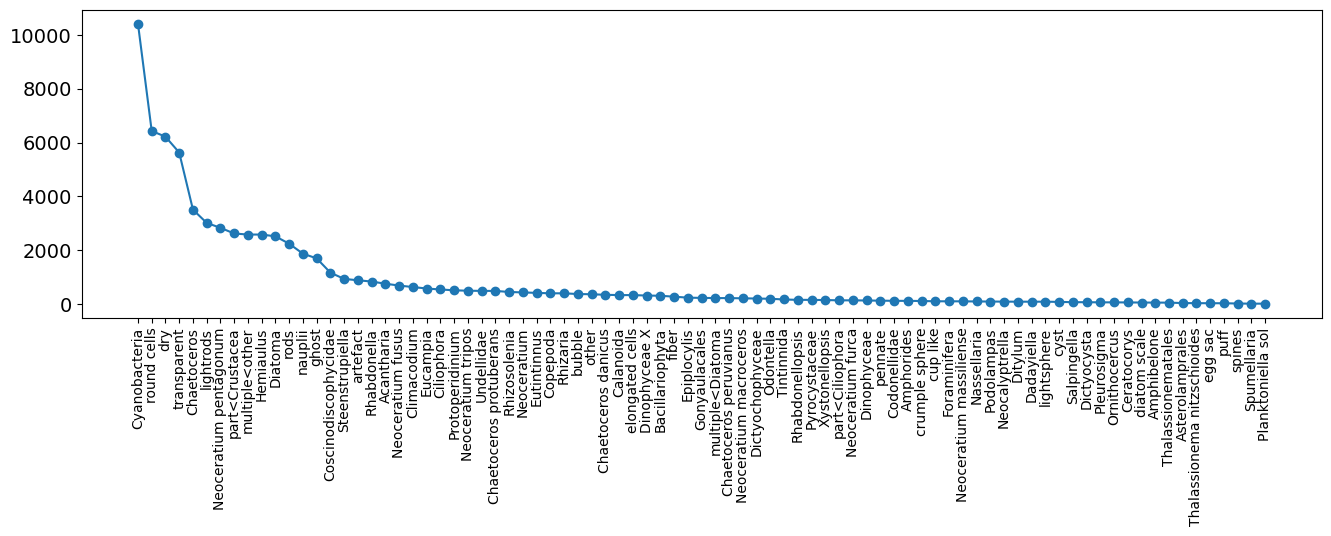

In [99]:
## ANSWER
fig,ax = plt.subplots(figsize = (16,4))
ax.plot(labels['label'].value_counts()[1:], 'o-')
plt.yticks(fontsize =14)
plt.xticks(rotation = 90,fontsize =10)
plt.show()

## Images exploration

Look at a few images interactively with

label: Rhizaria, images shapes: 66 x 68


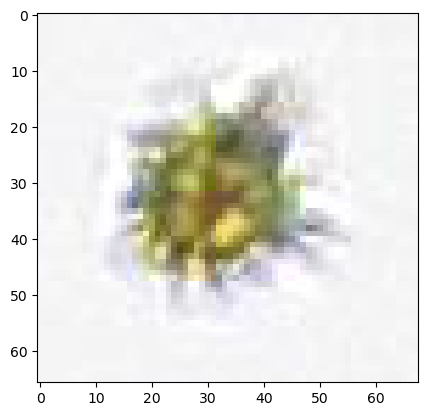

interactive(children=(IntSlider(value=0, description='image_index', max=123174), Output()), _dom_classes=('wid…

In [100]:
def images_exploration(image_index = 0):
  image_path = osp.join('planktoscope/images',labels.iloc[image_index]['image'])
  img = mpimg.imread(image_path)
  imgplot = plt.imshow(img)
  print(f"label: {labels.iloc[image_index]['label']}, images shapes: {img.shape[0]} x {img.shape[1]}")

interact(images_exploration, image_index=widgets.IntSlider(min=0, max=labels.shape[0], step=1, value=0));

## Split in train, val, test

We will take 10 images per class for test and val splits and a maximum of n images for training (to give similar weights to all classes during training and compensate for the class imbalance).

In [101]:
# encode labels as 0, 1, 2, 3
# this is necessary for pytorch
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels.label)
labels['int_label'] = le.transform(labels.label)

# count classes
num_classes = len(le.classes_)
print('Number of classes:', num_classes)

# shuffle rows (to take random samples)
# NB: I set random_state=1 here for replicability
labels = labels.sample(frac=1, random_state=1)

# maximum number of image per class
n_max = 120

# initialise lists which will contain tuples ('path/to/image',int_of_class)
# which will be used in the data loader below
test_samples  = []
val_samples   = []
train_samples = []

for this_label in list(le.classes_):
    # get data for this class
    df = labels.loc[labels.label == this_label]
    
    # get the 10 first images for test
    for i in range(0,10):
        test_samples.append(('planktoscope/images/' + df.image.iloc[i],
                             df.int_label.iloc[i]))
    # the 10 next for val
    for i in range(10,20):
        val_samples.append(('planktoscope/images/' + df.image.iloc[i],
                             df.int_label.iloc[i]))
    
    # and the remainder (or n_max) for train
    n = min(df.shape[0],(n_max+20))
    for i in range(20,n-1):
        train_samples.append(('planktoscope/images/' + df.image.iloc[i],
                             df.int_label.iloc[i]))


Number of classes: 84


In [102]:
print('test  :', len(test_samples))
print('val   :', len(val_samples))
print('train :', len(train_samples))

test  : 840
val   : 840
train : 8275


In [103]:
test_sample[1]

('planktoscope/images/241828062.jpg', 0)

## Create a data loader for PyTorch

We define here a PyTorch data loader (a piece of code that loads images from the disk and prepare them for the network) that takes as input a list of tuples of type (image paths, class id) such as the ones we created above.

In [106]:
from torchvision import datasets, transforms
from torchvision.datasets.folder import ImageFolder, default_loader

class PlanktonDataset(ImageFolder):
    # initialise the loader
    def __init__(self, samples=None, transform=None, target_transform=None, loader=default_loader):
        self.samples = samples
        
        # data augmentation function
        # (to be defined)
        self.transform = transform
        self.target_transform = target_transform

        # loader function
        self.loader = loader

        # print the number of images
        print(f"dataset size = {len(self.samples)}")

We define here the data-augmentation for training and evaluation of the model. If you finish earlier don't hesitate to test other kind of data-augmentation like RandomResizedCrop for the training or Tencrop for evaluation. See [Torchvision doc](https://pytorch.org/vision/stable/transforms.html).

In [107]:
# data preparation for testing
def get_transforms_test(input_size, crop=1.0):
    # mean and std intensity of ImageNet
    # (since this is what the model is pre-trained on)
    mean, std = [0.485, 0.456, 0.406],[0.229, 0.224, 0.225]

    resized_size=int(input_size/crop) 
    
    transformations = {}
    transformations= transforms.Compose(
        # resize (the smallest size) to the input size
        [transforms.Resize(resized_size, interpolation=3),
        # crop the middle to get a square
        # (NB: we're loosing data for the long images here)
         transforms.CenterCrop(input_size),
        # convert into a tensor
         transforms.ToTensor(),
        # normalize color channels
         transforms.Normalize(mean, std)])
    return transformations

# data augmentation for training
# same as before but add some random resizing, flip and jittering
def get_transforms_train(input_size, crop=1.0):
    mean, std = [0.485, 0.456, 0.406],[0.229, 0.224, 0.225]
    transformations = {}
    transformations= transforms.Compose(
        [transforms.RandomResizedCrop(input_size, interpolation=3),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.0),
         transforms.ToTensor(),
         transforms.Normalize(mean, std)])
    return transformations

In [108]:
# create datasets in PyTorch format

# choose an input size (in px)
image_size = 224 

# define the data
training_data = PlanktonDataset(train_samples, get_transforms_train(image_size))
test_data     = PlanktonDataset(test_samples, get_transforms_test(image_size))
val_data      = PlanktonDataset(val_samples, get_transforms_test(image_size))

# create the data loaders from these datasets
from torch.utils.data import DataLoader

# choose a batch size (larger is better, as long as GPU-RAM is available)
batch_size = 512

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, drop_last = True)
test_dataloader  = DataLoader(test_data, batch_size=batch_size, shuffle=False)
val_dataloader   = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# NB: we don't shuffle the order of the images for test and val

total_step = len(training_data) // batch_size

dataset size = 8275
dataset size = 840
dataset size = 840


# Define ViT model

## Architecture

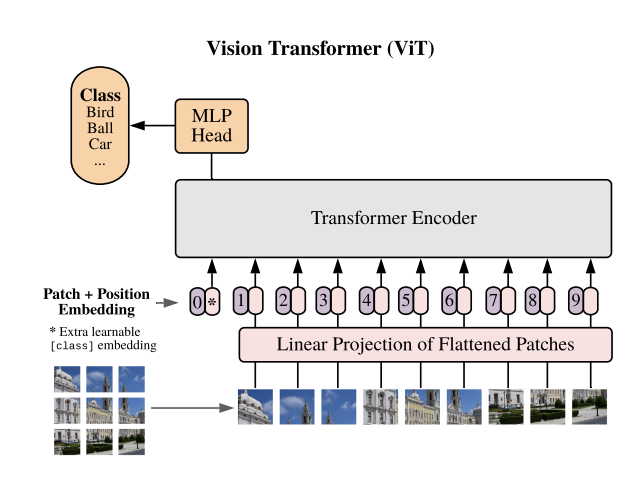

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from functools import partial

from timm.models.vision_transformer import PatchEmbed , _cfg

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model

The position encoding in transformers depends on the size of the input. So we have to resize it if we use a pre-trained model at a different resolution.

In [65]:
def resize_pos_embed(posemb, posemb_new):
    ntok_new = posemb_new.shape[1]
    ntok_old = posemb.shape[1]
    gs_old = int(math.sqrt(ntok_old))
    gs_new = int(math.sqrt(ntok_new))
    posemb_grid = posemb.reshape(1, gs_old, gs_old, -1).permute(0, 3, 1, 2)
    posemb_grid = torch.nn.functional.interpolate(posemb_grid, size=(gs_new, gs_new), mode='bicubic')
    posemb_grid = posemb_grid.permute(0, 2, 3, 1).reshape(1, gs_new * gs_new, -1)
    return posemb_grid

We define here a function in order to load a pre-trained checkpoint

In [66]:
def load_checkpoint(model, pretrained_dict):
    model_dict = model.state_dict()
    for k in model_dict.keys():
        if(('module.'+k) in pretrained_dict.keys()):
            if model_dict[k].size()==pretrained_dict.get(('module.'+k)).size():
                model_dict[k]=pretrained_dict.get(('module.'+k))
       
        else:

            if(k in pretrained_dict.keys()):
                if model_dict[k].size()==pretrained_dict.get(k).size():
                    model_dict[k]=pretrained_dict.get(k)
                else:
                    print('keys '+str(k)+' erase no load from checkpoint')
            else:
                print('keys '+str(k)+' missing')


    try:           
        if not pretrained_dict['module.pos_embed'].size() == model_dict['pos_embed'].size():
            pos_current = pretrained_dict['module.pos_embed']
            pos_future = model_dict['pos_embed']
            model_dict['pos_embed'] = resize_pos_embed(pos_current,pos_future)
    except:
        print('no pos_embed')
    return model_dict
    

We define here the attention module of transformers:

$x$: Tensor - Batch size (B) $\times$ Number of tokens (N) $\times$ working dimensions (d)

σ: softmax

$n_h$: #nb heads

h: $\frac{d}{n_h}$

$q = W_q x + b_q$

$k = W_k x + b_k$

$v = W_v x + b_v$

$W_a: σ(qk^T/\sqrt h)$

$out = W_o (W_a V)^T + b_o$

In [67]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.id = nn.Identity()

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # rescale
        q = q * self.scale

        # matrix multiplication (through @)
        # get a matrix of dimension B x h x N x N
        attn = (q @ k.transpose(-2, -1))
        # store output of this layer
        attn = self.id(attn)
        # softmax on final dimension
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # reshuffle dimensions and reshape
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

We define the feed forward network of transformers (FFN). This is a multi-layers perceptron.

$W_1 x + b_1$

$GELU(x)$

$W_2 x + b_2$

In [68]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, bias=True, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

We define here the transformers main block:

$ x + ATTN(LN(x))$

$ x + MLP(LN(x))$


In [69]:
class Layer_scale_init_Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm,Attention_block = Attention,Mlp_block=Mlp
                 ,init_values=1e-4):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention_block(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp_block(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)
        self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)

    def forward(self, x):
        x = x + self.drop_path(self.gamma_1 * self.attn(self.norm1(x)))
        x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
        return x

In [70]:


    
class vit_models(nn.Module):
    """ Vision Transformer with LayerScale (https://arxiv.org/abs/2103.17239) support
    taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
    with slight modifications
    """
    def __init__(self, img_size=224,  patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, global_pool=None,
                 block_layers = Layer_scale_init_Block,
                 Patch_layer=PatchEmbed,act_layer=nn.GELU,
                 Attention_block = Attention, Mlp_block=Mlp,
                dpr_constant=True,init_scale=1e-4,
                mlp_ratio_clstk = 4.0):
        super().__init__()
        
        self.dropout_rate = drop_rate

            
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim

        self.patch_embed = Patch_layer(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))

        dpr = [drop_path_rate for i in range(depth)]
        self.blocks = nn.ModuleList([
            block_layers(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=0.0, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                act_layer=act_layer,Attention_block=Attention_block,Mlp_block=Mlp_block,init_values=init_scale)
            for i in range(depth)])
        

        
            
        self.norm = norm_layer(embed_dim)

        self.feature_info = [dict(num_chs=embed_dim, reduction=0, module='head')]
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head
    
    def get_num_layers(self):
        return len(self.blocks)
    
    def reset_classifier(self, num_classes):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        
        x = x + self.pos_embed
        
        x = torch.cat((cls_tokens, x), dim=1)
            
        for i , blk in enumerate(self.blocks):
            x = blk(x)
            
        x = self.norm(x)
        return x[:, 0]

    def forward(self, x):

        x = self.forward_features(x)
        
        if self.dropout_rate:
            x = F.dropout(x, p=float(self.dropout_rate), training=self.training)
        x = self.head(x)
        
        return x


    

In [71]:


def deit_tiny_patch16_LS(pretrained=False, img_size=224, pretrained_21k = False,   **kwargs):
    model = vit_models(
        img_size = img_size, patch_size=16, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),block_layers=Layer_scale_init_Block, **kwargs)
    
    return model
    
    
def deit_small_patch16_LS(pretrained=False, img_size=224, pretrained_21k = False,  **kwargs):
    model = vit_models(
        img_size = img_size, patch_size=16, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),block_layers=Layer_scale_init_Block, **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        name = 'https://dl.fbaipublicfiles.com/deit/deit_3_small_'+str(224)+'_'
        if pretrained_21k:
            name+='21k.pth'
        else:
            name+='1k.pth'
            
        checkpoint = torch.hub.load_state_dict_from_url(
            url=name,
            map_location="cpu", check_hash=True
        )
        new_dict = load_checkpoint(model, checkpoint["model"])
        model.load_state_dict(new_dict)

    return model

def deit_medium_patch16_LS(pretrained=False, img_size=224, pretrained_21k = False, **kwargs):
    model = vit_models(
        patch_size=16, embed_dim=512, depth=12, num_heads=8, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),block_layers = Layer_scale_init_Block, **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        name = 'https://dl.fbaipublicfiles.com/deit/deit_3_medium_'+str(224)+'_'
        if pretrained_21k:
            name+='21k.pth'
        else:
            name+='1k.pth'
            
        checkpoint = torch.hub.load_state_dict_from_url(
            url=name,
            map_location="cpu", check_hash=True
        )
        new_dict = load_checkpoint(model, checkpoint["model"])
        model.load_state_dict(new_dict)
    return model 

def deit_base_patch16_LS(pretrained=False, img_size=224, pretrained_21k = False,  **kwargs):
    model = vit_models(
        img_size = img_size, patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),block_layers=Layer_scale_init_Block, **kwargs)
    if pretrained:
        name = 'https://dl.fbaipublicfiles.com/deit/deit_3_base_'+str(224)+'_'
        if pretrained_21k:
            name+='21k.pth'
        else:
            name+='1k.pth'
            
        checkpoint = torch.hub.load_state_dict_from_url(
            url=name,
            map_location="cpu", check_hash=True
        )
        new_dict = load_checkpoint(model, checkpoint["model"])
        model.load_state_dict(new_dict)
    return model
    
def deit_large_patch16_LS(pretrained=False, img_size=224, pretrained_21k = False,  **kwargs):
    model = vit_models(
        img_size = img_size, patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),block_layers=Layer_scale_init_Block, **kwargs)
    if pretrained:
        name = 'https://dl.fbaipublicfiles.com/deit/deit_3_large_'+str(224)+'_'
        if pretrained_21k:
            name+='21k.pth'
        else:
            name+='1k.pth'
            
        checkpoint = torch.hub.load_state_dict_from_url(
            url=name,
            map_location="cpu", check_hash=True
        )
        new_dict = load_checkpoint(model, checkpoint["model"])
        model.load_state_dict(new_dict)
    return model
    
def deit_huge_patch14_LS(pretrained=False, img_size=224, pretrained_21k = False,  **kwargs):
    model = vit_models(
        img_size = img_size, patch_size=14, embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),block_layers = Layer_scale_init_Block, **kwargs)
    if pretrained:
        name = 'https://dl.fbaipublicfiles.com/deit/deit_3_huge_'+str(224)+'_'
        if pretrained_21k:
            name+='21k_v1.pth'
        else:
            name+='1k_v1.pth'
            
        checkpoint = torch.hub.load_state_dict_from_url(
            url=name,
            map_location="cpu", check_hash=True
        )
        new_dict = load_checkpoint(model, checkpoint["model"])
        model.load_state_dict(new_dict)
    return model

## Training with pre-trained models

### Data-Augmentation

### Datasets

We define here the batch size and image size

dataset size = 7804
dataset size = 840
dataset size = 840


#### Validate fonction

We define the function to evaluate our architectures

In [74]:
import time
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.reshape(1, -1).expand_as(pred))
        return [correct[:k].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

def validate(val_loader, model):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    criterion = nn.CrossEntropyLoss()

    target_list = []
    pred_list = []



    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        last_idx = len(val_loader) - 1
        for i, (images, target) in enumerate(val_loader):
            batch_idx = i
            last_batch = batch_idx == last_idx
            images = images.cuda()
            target = target.cuda()

            # compute output
            with torch.cuda.amp.autocast(enabled = False):
                output = model(images)
                loss = criterion(output, target)


            # measure accuracy and record loss
            try:
                acc1, acc5 = accuracy(output, target, topk=(1, 5))
            except:
                acc1, acc5 = accuracy(output, target, topk=(1, 2))
                
            reduced_loss = loss.data
            target_list.extend(target.cpu().reshape(-1).tolist())
            pred_list.extend(output.detach().cpu().argmax(dim=-1).reshape(-1).tolist())
            losses.update(reduced_loss.item(), images.size(0))
            top1.update(acc1.item(), images.size(0))
            top5.update(acc5.item(), images.size(0))

            batch_time.update(time.time() - end)
            end = time.time()





        print('* Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f} loss {losses.avg:.3f}'
              .format(top1=top1, top5=top5, losses=losses))

    return pred_list, target_list

#### model

We choose the model to train

In [75]:
from torchvision.models import resnet18, ResNet18_Weights, resnet50, ResNet50_Weights

finetune_fc_only = False
model_type = "resnet18"

nb_classes = len(list(dict_images_by_labels.keys()))

if model_type == "deit-s":
  model = deit_small_patch16_LS(pretrained=True, img_size=image_size, pretrained_21k = True, drop_path_rate = 0.05)
  model.reset_classifier(nb_classes)
  for name_p , p in model.named_parameters():
    p.requires_grad = not finetune_fc_only

  model.head.weight.requires_grad = True
  model.head.bias.requires_grad = True
elif model_type == "resnet50":
  model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
  model.fc = nn.Linear(2048,nb_classes)
  for name_p , p in model.named_parameters():
    p.requires_grad = not finetune_fc_only

  model.fc.weight.requires_grad = True
  model.fc.bias.requires_grad = True
else:
  model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
  model.fc = nn.Linear(512,nb_classes)

  for name_p , p in model.named_parameters():
    p.requires_grad = not finetune_fc_only

  model.fc.weight.requires_grad = True
  model.fc.bias.requires_grad = True
model.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ml4oceans24/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
52.5%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Optimizer

In [76]:
import numpy as np

def cosine_scheduler(base_value, final_value, epochs, niter_per_ep, warmup_epochs=0, start_warmup_value=0):
    warmup_schedule = np.array([])
    warmup_iters = warmup_epochs * niter_per_ep
    if warmup_epochs > 0:
        warmup_schedule = np.linspace(start_warmup_value, base_value, warmup_iters)

    iters = np.arange(epochs * niter_per_ep - warmup_iters)
    schedule = final_value + 0.5 * (base_value - final_value) * (1 + np.cos(np.pi * iters / len(iters)))

    schedule = np.concatenate((warmup_schedule, schedule))
    assert len(schedule) == epochs * niter_per_ep
    return schedule


We define the optimizer and the learning rate scheduler for our training

In [77]:
from torch import optim as optim

nb_epochs = 50
optimizer =  optim.AdamW(model.parameters(), lr=5e-5, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.05)

#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3,8,12], gamma=0.1)
lr_schedule = cosine_scheduler(
        5e-5,  
        1e-5,
        nb_epochs, len(train_dataloader),
        warmup_epochs=3,
        start_warmup_value=1e-6,
    )


In order to reduce memory consumption it is possible to train the model with a smaller floating pointrepresentation (FLOAT 16)

In [78]:
from timm.utils import NativeScaler
loss_scaler = NativeScaler()
max_norm = 1.0
fp16 = True

Label smoothing, cutmix and Mixup are some very popular training recipes in order to have good performance with vision transformers

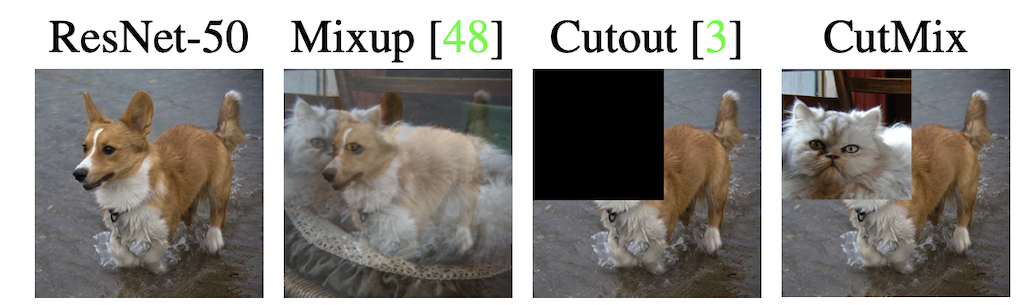

In [79]:
from timm.data import Mixup
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy

loss_fn = LabelSmoothingCrossEntropy(0.1)

mixup_fn = None
mixup_active = True
if mixup_active:
    mixup_fn = Mixup(
        mixup_alpha=0.8, cutmix_alpha=1.0, cutmix_minmax=None,
        prob=1.0, switch_prob=0.5, mode='batch',
        label_smoothing=0.1, num_classes=nb_classes)
    loss_fn = SoftTargetCrossEntropy()

#### Training

In [80]:
MB = 1024.0 * 1024.0

running_loss = 0
start_time = time.time()
log_freq = 3
for epoch in range(nb_epochs):
    optimizer.zero_grad()
    model.train()
    for step, data in enumerate(train_dataloader):
        it = len(train_dataloader) * epoch + step  # global training iteration
        for i, param_group in enumerate(optimizer.param_groups):
            param_group["lr"] = lr_schedule[it]

        input, target = data
        input = input.cuda()
        target = target.cuda()
        if mixup_fn is not None:
            input, target = mixup_fn(input, target)

        with torch.cuda.amp.autocast(enabled = fp16):
          output = model(input)
          loss = loss_fn(output, target)
        
        
        if fp16:
          optimizer.zero_grad()
          loss_scaler(loss, optimizer, clip_grad=max_norm,
                      parameters=model.parameters(), create_graph=False)
        else:
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

        
        running_loss += loss.item()
        if (step + 1)%log_freq == 0:
          memory_usage = torch.cuda.max_memory_allocated() / MB
          print(f"{epoch}:{step}/{total_step}, loss:{running_loss/log_freq},lr: {optimizer.param_groups[0]['lr']:.8f}, mem: {memory_usage:.1f} MB, {time.time()-start_time:.2f} s")
          running_loss = 0
          start_time = time.time()

    #scheduler.step()
    if epoch%1 ==0:
      validate(val_dataloader,model)



0:2/15, loss:4.636062939961751,lr: 0.00000323, mem: 7521.0 MB, 16.81 s
0:5/15, loss:4.66864554087321,lr: 0.00000657, mem: 7521.0 MB, 14.92 s
0:8/15, loss:4.6250020662943525,lr: 0.00000991, mem: 7521.0 MB, 15.20 s
0:11/15, loss:4.609048366546631,lr: 0.00001325, mem: 7521.0 MB, 15.85 s
0:14/15, loss:4.608050187428792,lr: 0.00001659, mem: 7521.0 MB, 15.97 s
* Acc@1 0.833 Acc@5 6.190 loss 4.563
1:2/15, loss:4.549681186676025,lr: 0.00001993, mem: 7521.0 MB, 21.41 s
1:5/15, loss:4.554030418395996,lr: 0.00002327, mem: 7521.0 MB, 12.92 s
1:8/15, loss:4.488149642944336,lr: 0.00002661, mem: 7521.0 MB, 14.45 s
1:11/15, loss:4.440735658009847,lr: 0.00002995, mem: 7521.0 MB, 15.39 s
1:14/15, loss:4.430975437164307,lr: 0.00003330, mem: 7521.0 MB, 15.32 s
* Acc@1 5.000 Acc@5 16.548 loss 4.332
2:2/15, loss:4.347360610961914,lr: 0.00003664, mem: 7521.0 MB, 20.41 s
2:5/15, loss:4.365550676981608,lr: 0.00003998, mem: 7521.0 MB, 14.57 s
2:8/15, loss:4.269977569580078,lr: 0.00004332, mem: 7521.0 MB, 14.42 

In [81]:
print("Evaluation on the train set")
validate(train_dataloader,model)
print()
print("Evaluation on the val set")
validate(val_dataloader,model)
print()

Evaluation on the train set
* Acc@1 56.159 Acc@5 82.969 loss 1.859

Evaluation on the val set
* Acc@1 54.881 Acc@5 84.405 loss 1.882



In [82]:
print("Evaluation on the test set")
y_pred, y_true = validate(test_dataloader,model)

Evaluation on the test set
* Acc@1 51.190 Acc@5 83.929 loss 1.903


Perf:

DeiT-S: 52.5

ResNet18

#### Confusion matrix

We visualize the confusion matrix  in order to interpret the prediction errors.

<AxesSubplot:>

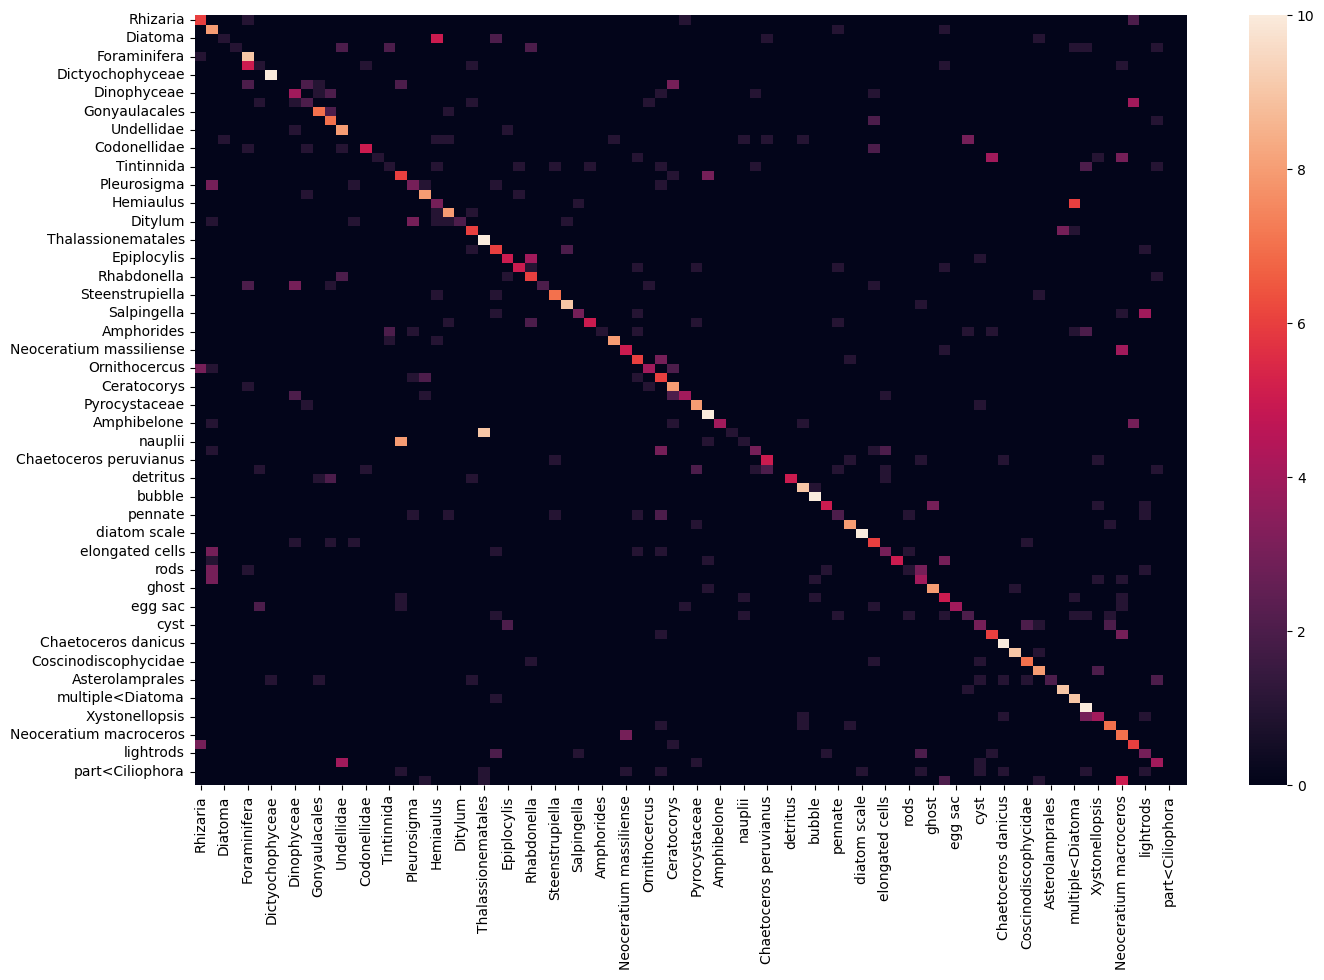

In [83]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


cf_matrix = confusion_matrix(y_true, y_pred)


df_cm = pd.DataFrame(cf_matrix, index = [id_to_lab[i] for i in range(cf_matrix.shape[0])],
                  columns = [id_to_lab[i] for i in range(cf_matrix.shape[1])])
plt.figure(figsize = (16,10))
sns.heatmap(df_cm, annot=False)

### Explore prediction

In [84]:
def images_exploration(image_index = 0):
  image_path = osp.join('/home/ml4oceans24/experiments/planktoscope_ml4oceans/images',labels.iloc[image_index]['image'])
  img = plt.imread(image_path)
  imgplot = plt.imshow(img)
  im = Image.open(image_path)
  im = get_transforms_test(image_size)(im)
  model.eval()
  with torch.no_grad():
    with torch.cuda.amp.autocast(enabled = True):
      out = model(im.unsqueeze(0).cuda())
      out = out.softmax(dim=-1)
      ind = int(out.cpu().argmax(dim=-1).reshape(-1))
      probs = float(out.cpu().max())
  
  print(f"label: {labels.iloc[image_index]['label']}, images shapes: {img.shape[0]} x {img.shape[1]}, predicted label: {id_to_lab[ind]} ({probs*100:.2f}%)")

interact(images_exploration, image_index=widgets.IntSlider(min=0, max=labels.shape[0], step=1, value=0));

interactive(children=(IntSlider(value=0, description='image_index', max=123174), Output()), _dom_classes=('wid…

### Visualize attention maps

In [85]:
class visualizer(nn.Module):
    #Slightly modified code from Lucidrains (https://github.com/lucidrains)
    #Original code: https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/recorder.py
    def __init__(self, model):
        super().__init__()
        self.model = model

        self.data = None
        self.recordings = []
        self.hooks = []
        self.hook_registered = False
        self.ejected = False

    def _hook(self, _, input, output):
        self.recordings.append(output.clone().detach())

        
    def _register_hook(self):
        for i in range(self.model.get_num_layers()):
            handle = self.model.blocks[i].attn.id.register_forward_hook(self._hook)
            self.hooks.append(handle)
        self.hook_registered = True
        
    def eject(self):
        self.ejected = True
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()
        return self.model

    def clear(self):
        self.recordings.clear()

    def record(self, x):
        recording = x.clone().detach()
        self.recordings.append(recording)

    def forward(self, img):
        assert not self.ejected, 'recorder has been ejected, cannot be used anymore'
        self.clear()

        if not self.hook_registered:
            self._register_hook()

        pred = self.model(img)
        return pred, self.recordings   

     

In [86]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def get_transforms_original(input_size=224,test_size=224,mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225],resize_im=False):

    transformations = transforms.Compose(
        [transforms.Resize(int(test_size), interpolation=3),  # to maintain same ratio w.r.t. 224 images
         transforms.CenterCrop(test_size)])


    return transformations

def get_transforms(input_size=224,test_size=224,mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225],resize_im=False):

    transformations = transforms.Compose(
        [transforms.Resize(int(test_size), interpolation=3),  # to maintain same ratio w.r.t. 224 images
         transforms.CenterCrop(test_size),
         transforms.ToTensor(),
         transforms.Normalize(mean, std)])

    return transformations

In [87]:
model.eval()
#remove gradients
for p in model.parameters():
    p.requires_grad = False
#add visualizer to get the attention map
models =  visualizer(model)


In [88]:
import cv2

def images_exploration(image_index = 0, layer_index = 0, head_index = 0):
  image_path = osp.join('/home/ml4oceans24/experiments/planktoscope_ml4oceans/images',labels.iloc[image_index]['image'])
  img = plt.imread(image_path)
  im = Image.open(image_path)
  fig, axs = plt.subplots(1, 3, figsize=(30, 10))
  #generate org image
  data_aug_org =get_transforms_original(im.size[0],im.size[1])
  im = data_aug_org(im)
  #generate sample image
  data_aug = get_transforms(image_size,image_size)
  sample = data_aug(im)
  sample = sample.unsqueeze(0)
  im = data_aug_org(im)
  #plot original image
  axs[0].imshow((np.array(1)* im))
  axs[0].grid(None)
  axs[0].axis('off')
  axs[0].set_title('Original image')
  #get attention maps
  model.eval()
  with torch.no_grad():
    with torch.cuda.amp.autocast(enabled = True):
      out, attn = models(sample.cuda())
      out = out.float().softmax(dim=-1)
      ind = int(out.cpu().argmax(dim=-1).reshape(-1))
      probs = float(out.cpu().max())
  ps = int(image_size/16)
  #softmax score without class token
  attn2 = attn[layer_index].clone().float()[0,head_index,0].reshape(ps*ps+1)[1:].softmax(dim=-1).reshape((ps,ps))
  mask = attn2.detach().cpu()
  mask = torch.nn.functional.interpolate(mask.reshape((1,1,ps,ps)), size=(im.size[1], im.size[0]), mode='bicubic')
  #resize attention map to original image size
  #mask = cv2.resize(mask/mask.max(), im.size)[..., np.newaxis]
  #mask = np.resize(mask/mask.max(), im.size)
  mask = mask.reshape(im.size[1], im.size[0],1).cpu().numpy()
  #normalize attention map
  mask =((mask - mask.min())/(mask.max() - mask.min()))
  result = ((mask) * im).astype("uint8")
  result = rgb2gray(result)
  #plot attention maps
  axs[1].imshow(result,cmap='cividis')
  axs[1].grid(None)
  axs[1].axis('off')
  axs[1].set_title('Attention map')



  axs[2].matshow(attn2.cpu().numpy(),cmap='cividis')
  axs[2].grid(None)
  axs[2].axis('off')
  axs[2].set_title(f"Attention matrix: layer {layer_index}, head {head_index}")
  plt.show()

  
  print(f"label: {labels.iloc[image_index]['label']}, images shapes: {img.shape[0]} x {img.shape[1]}, predicted label: {id_to_lab[ind]} ({probs*100:.2f}%)")

interact(images_exploration, image_index=widgets.IntSlider(min=0, max=labels.shape[0], step=1, value=0), 
         layer_index=widgets.IntSlider(min=0, max=models.model.get_num_layers()-1, step=1, value=0),
         head_index=widgets.IntSlider(min=0, max=5, step=1, value=0));

AttributeError: 'ResNet' object has no attribute 'get_num_layers'

In [ ]:
pwd